# Customer Total Revenue

- Goal is to calculate total revenue generated by each customer by grouping them by customer ID and calculating the sum of the sales amount

In [18]:
# Sales Table
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, col, year, quarter, month

# Start a Spark session
spark = SparkSession.builder \
    .appName("sales_data_preparedcsv") \
    .getOrCreate()

# Path to your CSV file
csv_path = "/Users/craigwilcox/Projects/smart-store-craigwilcox/Data/prepared/sales_data_prepared.csv"

# Load CSV into DataFrame
df_sales = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(csv_path)

# Show data
df_sales.show()

25/04/18 18:08:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------+--------+----------+---------+-------+----------+----------+-----------------+--------+
|transactionid|saledate|customerid|productid|storeid|campaignid|saleamount|loyaltypercentage|billtype|
+-------------+--------+----------+---------+-------+----------+----------+-----------------+--------+
|          550|  1/6/24|      1008|      102|    404|         0|      39.1|                5|    Paid|
|          551|  1/6/24|      1009|      105|    403|         0|     19.78|                5|    Paid|
|          552| 1/16/24|      1004|      107|    404|         0|     335.1|                5|    Paid|
|          553| 1/16/24|      1006|      102|    406|         0|     195.5|                5| Invoice|
|          554| 1/25/24|      1005|      102|    405|         0|     117.3|                5| Invoice|
|          555| 1/25/24|      1001|      101|    401|         0|   2379.36|               20| Invoice|
|          556| 1/29/24|      1009|      104|    403|         0|     172.

In [19]:
# Customers Tables

spark.conf.set("spark.sql.caseSensitive", "false")

# Path to your customer CSV file
customer_csv_path = "/Users/craigwilcox/Projects/smart-store-craigwilcox/Data/prepared/customers_data_prepared.csv"

# Load customer data into DataFrame
df_customer = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(customer_csv_path)

# Register the DataFrame as a temporary view
df_customer.createOrReplaceTempView("customer")

from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder.appName("SmartSales").getOrCreate()

# Register DataFrames as temporary views (if not already done)
df_sales.createOrReplaceTempView("sales")
df_customer.createOrReplaceTempView("customer")

# Write query using Spark SQL
df_top_customers = spark.sql("""
    SELECT c.Name, SUM(s.saleamount) AS total_spent
    FROM sales s
    JOIN customer c ON s.customerid = c.CustomerID
    GROUP BY c.Name
    ORDER BY total_spent DESC
""")

# Show Spark results
df_top_customers.show()

# Convert to Pandas for use with charts
import pandas as pd
df_top_customers_pd = df_top_customers.toPandas()

25/04/18 18:08:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+----------------+------------------+
|            Name|       total_spent|
+----------------+------------------+
|   William White|23752.520000000004|
|Hermione Granger|          22822.54|
|   Susan Johnson|           12422.6|
|       Chewbacca|11813.439999999999|
|   Tiffany James|          11715.82|
| Hermione Grager|           8750.94|
|    Wylie Coyote|           7434.44|
|          Dr Who|4064.8599999999997|
|       Dan Brown|2427.2999999999997|
|    Jason Bourne|           1806.34|
|      Tony Stark|           1545.54|
+----------------+------------------+



In [20]:
# Step 1: Ensure the `saledate` is in date format if it's a string
df_sales = df_sales.withColumn("saledate", to_date(col("saledate"), "MM-dd-yy"))

# Step 2: Filter the data (Make sure `saledate` is in date format for comparison)
df_filtered = df_sales.filter(df_sales.saledate >= "2023-01-01")

# Step 3: Group by `billtype` and `storeid`, sum `amount`
df_sales.groupby("billtype", "storeid").sum("saleamount").show()

# Step 4: Extract `year`, `quarter`, and `month` from `saledate`
df_sales = df_sales.withColumn("year", year(df_sales.saledate))
df_sales = df_sales.withColumn("quarter", quarter(df_sales.saledate))
df_sales = df_sales.withColumn("month", month(df_sales.saledate))

# Step 5: Group by `year`, `quarter`, and `month`, sum `saleamount`
df_sales.groupby("year", "quarter", "month").sum("saleamount").show()

+--------+-------+------------------+
|billtype|storeid|   sum(saleamount)|
+--------+-------+------------------+
| Invoice|    406|            391.82|
| Invoice|    402| 4940.400000000001|
| Invoice|    404|             431.0|
|  Credit|    406|3375.6800000000003|
|  Credit|    401|            7889.6|
|  Credit|    402|          23673.66|
| Invoice|    403|            593.98|
|  Credit|    405|1367.6399999999999|
|  Credit|    404|          12474.66|
| Invoice|    405|           6640.54|
|    Paid|    403|           2846.54|
|    Paid|    402|1642.9199999999998|
|  Credit|    403|            793.12|
|    Paid|    404|453.32000000000005|
| Invoice|    401|16515.920000000002|
|    Paid|    406|           7948.32|
|    Paid|    401|           8097.94|
|    Paid|    405| 8479.279999999999|
+--------+-------+------------------+

+----+-------+-----+------------------+
|year|quarter|month|   sum(saleamount)|
+----+-------+-----+------------------+
|NULL|   NULL| NULL|108556.34000000004|
+--

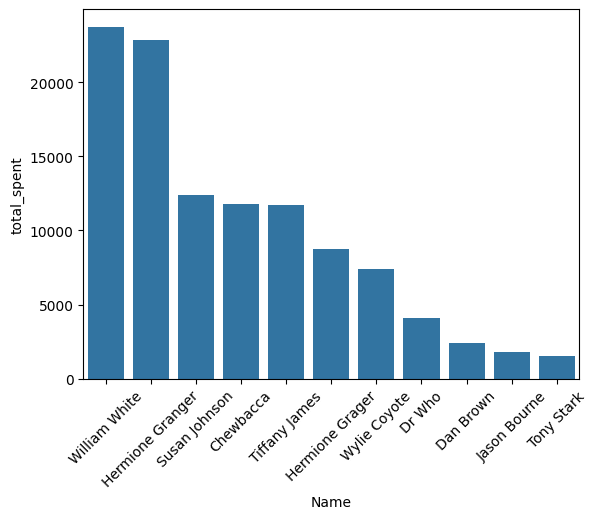

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_top_customers_pd, x="Name", y="total_spent")
plt.xticks(rotation=45)
plt.show()